### Name: Hao He

# 1.The analysis

### Import package

In [1]:
import pandas as pd 
from datetime import timedelta, date
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Read, clean and explore the data.

In [2]:
data=pd.read_csv('daily_revenue.csv')

In [3]:
data["CPM"] = 1000*data["revenue"]/data["pageviews"]
data.drop_duplicates(inplace=True)
#data.info()
data.head(5)

,date,site,revenue,pageviews,CPM
0,2016-07-13,wearewearside,0.539353,389,1.386513
1,2016-07-13,projectspurs,3.588072,2353,1.524892
2,2016-07-13,totalbarca,5.130714,1228,4.178106
3,2016-07-14,projectspurs,4.264064,2762,1.543832
4,2016-07-14,totalbarca,2.280724,539,4.231400


In [4]:
date2=data.groupby('date').count().index.max()
date1=data.groupby('date').count().index.min()
print(date1)
print(date2)
def daterange(date1, date2):
    for n in range(int((date2 - date1).days)+1):
        yield date1 + timedelta(n)
start_dt = date(2016, 7, 13)
end_dt = date(2017, 5, 31)
date_line=[dt.strftime("%Y-%m-%d") for dt in daterange(start_dt, end_dt)];
date_line=pd.Series(date_line).rename('date')
print("The total number of date in the data:",len(date_line))
n_sites = len(data.groupby('site').count())
print('The number of sites in the data:',n_sites)

2016-07-13
2017-05-31
The total number of date in the data: 323
The number of sites in the data: 173


### Transform to time series.

In [5]:
data_new=pd.concat([pd.Series(range(len(date_line))),date_line], axis = 1)
for site in data.site.unique():
    a=data[data.site == site][['date','CPM']]
    a.rename(columns={ "CPM": site}, inplace=True)
    data_new=pd.merge(data_new,a,how='left',on='date')
    data_new[site][data_new[site].isna()] = 0   # replace NaN by 0. 

In [6]:
data_new['date'] = pd.to_datetime(data_new['date']);
data_new.set_index('date',inplace=True);
del data_new[0];

### Randomly choose a site to explore

In [7]:
rand=0
y=data_new.iloc[:,rand]
y=y.reset_index(level=0)
site_name=y.columns[1]
y.head(3)

,date,wearewearside
0,2016-07-13,1.386513
1,2016-07-14,1.403804
2,2016-07-15,0.910647


In [8]:
# standardize data
from sklearn.preprocessing import StandardScaler
df = y
data = df[site_name]
scaler = StandardScaler()
data=data.values.reshape(-1,1)
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

### Explore the time series from a random site. 
1. I utilize isloationForest the find the anomalies.
2. However, there are different methods for finding anomalies such as SVM, Kmean,but I find that isloationForest has better performance. 

In [20]:
from sklearn.ensemble import IsolationForest
# train isolation forest model
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly2'] = pd.Series(model.predict(data))
# visualization
plt.figure(figsize=(10,6))
a = df.loc[df['anomaly2'] == -1, ['date', site_name]] #anomaly
plt.plot(df['date'], df[site_name], color='blue', label = 'Normal')
plt.scatter(list(a['date']),list(a[site_name]), color='red', label = 'Anomaly')
plt.legend()
plt.show();

NameError: name 'outliers_fraction' is not defined

### Use SARIMA algorithm for forecasting. 
* SARIMA stands for Seasonal Auto Regressive Integrated Moving Average.

In [9]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

In [10]:
actual_vals=y[site_name];

* Split the training and testing sets.
    * 200 training 
    * 123 testing 

In [11]:
train, test = actual_vals[0:200].values, actual_vals[200:].values
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)
n_train=len(train)
n_test=len(test)

* Utilize the first part of data(200 training set) to train the model.
* Next, use the second part of the data(123 testing set) to evaluate the result. 
* Conpare the predictions and actual data.

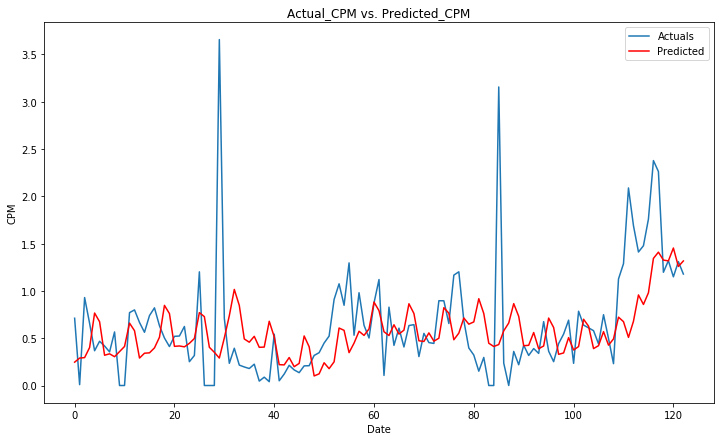

In [12]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.SARIMAX(history,
                           order=my_order,
                           seasonal_order=my_seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
figsize=(12, 7)
plt.figure(figsize=figsize)
plt.plot(test,label='Actuals')
plt.plot(predictions, color='red',label='Predicted')
plt.legend(loc='upper right')
plt.title('Actual_CPM vs. Predicted_CPM')
plt.xlabel('Date')
plt.ylabel('CPM')
pyplot.show()

## Detect anomalies:
1. Compute the error term(actual- predicted).
2. Compute the rolling mean and rolling standard deviation.
3. Classify data with an error of 1.5,1.75 and 2 standard deviations as limits for low,medium and high anomalies. (5% of data point would be identified anomalies based on this property)

In [13]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window,min_periods=1).mean()
    df['deviation'] = df['error'].rolling(window=window,min_periods=1).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))] 
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan) # where(condition, true, false)
    df = df.sort_values(by='date', ascending=False)
    df.load_date = pd.to_datetime(df['date'].astype(str), format="%Y-%m-%d")
    return df

In [14]:
predicted_df=pd.DataFrame()
predicted_df['date']=y['date'][200:]
predicted_df['actuals']=test
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']

In [20]:
predicted_df.head(10)

,date,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points
0,2017-01-29,0.710929,0.246841,0.464088,65.279073,0.464088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,0.464088
1,2017-01-30,0.009137,0.289915,-0.280777,-3072.813699,0.091655,0.526699,-0.961743,1.145054,-0.830068,1.013379,-0.698394,0.881704,3,0,NEGATIVE,NaN
2,2017-01-31,0.929525,0.294821,0.634704,68.282651,0.272672,0.486833,-0.700995,1.246338,-0.579287,1.124630,-0.457578,1.002922,4,0,POSITIVE,NaN
3,2017-02-01,0.657033,0.401418,0.255615,38.904392,0.268407,0.397589,-0.526771,1.063586,-0.427374,0.964189,-0.327977,0.864791,3,0,NEGATIVE,NaN
4,2017-02-02,0.367451,0.765778,-0.398327,-108.402811,0.135060,0.455483,-0.775906,1.046027,-0.662035,0.932156,-0.548164,0.818285,3,0,NEGATIVE,NaN
5,2017-02-03,0.467407,0.674217,-0.206810,-44.246345,0.078082,0.430640,-0.783199,0.939363,-0.675539,0.831703,-0.567879,0.724043,3,0,NEGATIVE,NaN
6,2017-02-04,0.417542,0.319850,0.097693,23.397078,0.080884,0.393189,-0.705494,0.867261,-0.607197,0.768964,-0.508900,0.670667,4,0,POSITIVE,NaN
7,2017-02-05,0.355363,0.334943,0.020420,5.746258,0.017502,0.355029,-0.692556,0.727561,-0.603799,0.638804,-0.515042,0.550047,4,0,POSITIVE,NaN
8,2017-02-06,0.566078,0.304391,0.261687,46.228108,0.094997,0.337859,-0.580721,0.770716,-0.496256,0.686251,-0.411791,0.601786,4,0,POSITIVE,NaN
9,2017-02-07,0.000000,0.358138,-0.358138,-inf,-0.046837,0.276322,-0.599480,0.505806,-0.530400,0.436725,-0.461320,0.367645,3,0,NEGATIVE,NaN


In [17]:
classify_df=detect_classify_anomalies(predicted_df,7)
classify_df.reset_index(inplace=True)
del classify_df['index']

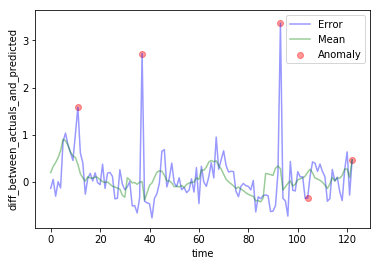

,date,actuals,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points
0,2017-05-31,1.177898,1.316322,-0.138424,-11.751793,0.195484,0.525782,-0.856080,1.247048,-0.724634,1.115603,-0.593189,0.984157,3,0,NEGATIVE,NaN
1,2017-05-30,1.309378,1.258070,0.051309,3.918551,0.326514,0.542716,-0.758918,1.411947,-0.623239,1.276268,-0.487560,1.140589,3,0,NEGATIVE,NaN
2,2017-05-29,1.148815,1.453029,-0.304213,-26.480605,0.407820,0.537220,-0.666620,1.482260,-0.532315,1.347955,-0.398010,1.213650,3,0,NEGATIVE,NaN
3,2017-05-28,1.319589,1.317320,0.002268,0.171909,0.516100,0.436783,-0.357466,1.389666,-0.248270,1.280471,-0.139074,1.171275,3,0,NEGATIVE,NaN
4,2017-05-27,1.196794,1.325498,-0.128704,-10.754019,0.660098,0.404082,-0.148066,1.468262,-0.047045,1.367241,0.053975,1.266221,1,2,NEGATIVE,NaN
5,2017-05-26,2.261638,1.409346,0.852292,37.684712,0.904148,0.361968,0.180211,1.628084,0.270703,1.537592,0.361195,1.447100,3,0,NEGATIVE,NaN
6,2017-05-25,2.377359,1.343498,1.033861,43.487789,0.869912,0.378640,0.112632,1.627191,0.207292,1.532532,0.301952,1.437872,4,0,POSITIVE,NaN
7,2017-05-24,1.759177,0.980388,0.778789,44.270054,0.779897,0.407003,-0.034110,1.593904,0.067641,1.492153,0.169392,1.390402,3,0,NEGATIVE,NaN
8,2017-05-23,1.477220,0.856773,0.620447,42.000989,0.631279,0.566257,-0.501235,1.763793,-0.359671,1.622229,-0.218106,1.480665,3,0,NEGATIVE,NaN
9,2017-05-22,1.410925,0.957176,0.453749,32.159682,0.552632,0.604924,-0.657216,1.762479,-0.505985,1.611248,-0.354754,1.460017,3,0,NEGATIVE,NaN


In [19]:
plt.plot(classify_df['error'],color='blue',label='Error',alpha =0.4)
plt.plot(classify_df['meanval'],color='green', label ='Mean',alpha =0.4)
a=classify_df[classify_df.anomaly_points.notna()].index
b=classify_df.anomaly_points[classify_df.anomaly_points.notna()]
plt.scatter(x =a, y=b, color='red',label ='Anomaly',alpha =0.4)
plt.legend()
plt.ylabel('diff_between_actuals_and_predicted')
plt.xlabel('time')
plt.show()
classify_df.head(10)

### By repeating above steps, I can conduct the anomalies detection for all the sites.

In [962]:
for i in range(len(data_new.columns)):
    y=data_new.iloc[:,i]
    y=y.reset_index(level=0)
    site_name=y.columns[1]
    y.head(3)
    df = y
    data = df[site_name]
    scaler = StandardScaler()
    data=data.values.reshape(-1,1)
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    actual_vals=y[site_name];
    train, test = actual_vals[0:200].values, actual_vals[200:].values
    if len(train[train==0])>0.8*len(train):
        print('More than 80% of training data equal to 0 in {}.'.format(site_name))
        continue  
    my_order = (1, 1, 1)
    my_seasonal_order = (0, 1, 1, 7)
    n_train=len(train)
    n_test=len(test)
    #Utilize SARIMA algorithm for forecasting.
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.SARIMAX(history,
                               order=my_order,
                               seasonal_order=my_seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    predicted_df=pd.DataFrame()
    predicted_df['date']=y['date'][200:]
    predicted_df['actuals']=test
    predicted_df['predicted']=predictions
    predicted_df.reset_index(inplace=True)
    del predicted_df['index']
    classify_df=detect_classify_anomalies(predicted_df,7)
    classify_df.reset_index(inplace=True)
    del classify_df['index']
    print('The following site has anomalies at the time below')
    print(site_name)
    print(classify_df[classify_df.anomaly_points.notna()]['date'])


The following site has anomalies at the time below
wearewearside
11    2017-05-20
37    2017-04-24
93    2017-02-27
104   2017-02-16
122   2017-01-29
Name: date, dtype: datetime64[ns]
More than 80% of training data equal to 0 in projectspurs.
The following site has anomalies at the time below
totalbarca
12    2017-05-19
93    2017-02-27
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
hoosierhuddle
19    2017-05-12
53    2017-04-08
94    2017-02-26
95    2017-02-25
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
therepublikofmancunia
35    2017-04-26
53    2017-04-08
96    2017-02-24
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
huskermax
95    2017-02-25
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
buffalofambase
122  

The following site has anomalies at the time below
videocelts
96    2017-02-24
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
raiders411
13    2017-05-18
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
cardinalconnect
20    2017-05-11
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
catchronicles
22    2017-05-09
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
sportsdaily
90    2017-03-02
97    2017-02-23
103   2017-02-17
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
mynhltraderumors
95    2017-02-25
96    2017-02-24
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
More than 80% of training data equal to 0 in justinbieber.
The following site has anomalies at the time

The following site has anomalies at the time below
dotapicker
30    2017-05-01
93    2017-02-27
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
readarsenal
6     2017-05-25
13    2017-05-18
20    2017-05-11
27    2017-05-04
34    2017-04-27
41    2017-04-20
48    2017-04-13
55    2017-04-06
62    2017-03-30
69    2017-03-23
76    2017-03-16
83    2017-03-09
97    2017-02-23
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
readwestbrom
16    2017-05-15
23    2017-05-08
30    2017-05-01
37    2017-04-24
44    2017-04-17
51    2017-04-10
58    2017-04-03
65    2017-03-27
72    2017-03-20
79    2017-03-13
93    2017-02-27
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
readceltic
96    2017-02-24
122   2017-01-29
Name: date, dtype: datetime64[ns]
The following site has anomalies at the time below
readwestham
122   

# 2. The steps of the analysis
1. Explore the data.
2. Use IsolationForest to find the anomalies. 
3. Split the data into training and testing
4. Utilize SARIMA algorithm for forecasting.
    * 200 data -> training 
    * 123 data -> testing 
5. Compared the predicton and actual data.
6. Compute the error term(actual- predicted).
7. Compute the rolling mean and rolling standard deviation.
8. Classify data with an error of 1.5,1.75 and 2 standard deviations as limits for low,medium and high anomalies. (5% of data point would be identified anomalies based on this property)

# 3. Potential concerns
1. The method I utilize above probably not the best way to make the prediction. I can write a Neural Network conducting the anomalies detection for time series forecasting, but it will take too much time for me to fit the model. 
2. There are too many missing values in the dataset(replaced by 0). Some sites do not have data in most of the date, making the model prediction less precise. 
    * How to solve
        * Deleting the sites which have more than 80 % of missing value in training data. 
        * Get more data.